In [46]:

# %pip install wordcloud
# %pip install praw

In [47]:
shoe_brand = 'Nike'

In [48]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [49]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
r = praw.Reddit(client_id='GJtzNYyCMIW-66t_xry24Q',
                     client_secret='ClyB_Id7qbhShlg4P43xqrLiyXPvyA',
                     user_agent='ljx597620034')

In [51]:
subreddit = r.subreddit(shoe_brand)

shoes_subreddit_top_posts = [*subreddit.top(limit=None)] # top posts all time

print(len(shoes_subreddit_top_posts))

999


In [52]:
shoes0 = shoes_subreddit_top_posts[0]

# pprint(vars(news0)) 
print(shoes0.title) # headline
print(shoes0.score) # upvotes
print(shoes0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(shoes0.created)) # date and time
print(shoes0.num_comments) # no. of comments
print(shoes0.upvote_ratio) # upvote / total votes
print(shoes0.total_awards_received) # no. of awards given

Yea I was that mom that messaged Nike asking questions 😅. Thought it wouldn't hurt to spam the internet to get Nike shoes to look at accommodating kids with special needs. To date we've yet to find a shoe that actually fits with Maddy's AFOs.
1395
1612239524.0
2021-02-01 23:18:44
49
0.99
14


In [53]:
title = [i.title for i in shoes_subreddit_top_posts]
shoes = pd.DataFrame({
    "title": title,
})
shoes.head()

,title
0,Yea I was that mom that messaged Nike asking q...
1,I made this hat out of 90’s Nike tags I sewed ...
2,😶
3,Nike Logo
4,A pair of custom Charizard Nikes my dad got me...


In [54]:
print(shoes_subreddit_top_posts[0].comments[0])
print(shoes_subreddit_top_posts[0].comments[0].body)


glpl8xn
Good luck hopefully they can pull something off but it might have been just too hard to make that design work in a much smaller form factor


In [56]:
lst = []
for i in shoes_subreddit_top_posts:
    for j in range(0, 1):
        lst.append(i.comments[j].body)


In [ ]:
lst2 = []
for i in shoes_subreddit_top_posts:
    for j in range(0, 1):
        lst.append(i.comments[j])


In [ ]:
shoes['comment0'] = lst
shoes['com_id0'] = lst2

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
res = [*shoes['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.6249, 'neg': 0.0, 'neu': 0.328, 'pos': 0.672},
 {'compound': 0.1027, 'neg': 0.329, 'neu': 0.286, 'pos': 0.386},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


In [ ]:
sentiment_df = pd.DataFrame.from_records(res)

shoes = pd.concat([shoes, sentiment_df], axis=1, join='inner')
shoes.head()

,title,neg,neu,pos,compound
0,Great Customer Service,0.000,0.328,0.672,0.6249
1,I lost my ultra boost 😒,0.329,0.286,0.386,0.1027
2,3 stripes for life \\\,0.000,1.000,0.000,0.0000
3,Adidas FOUND ME!,0.000,1.000,0.000,0.0000
4,Fingers crossed,0.000,1.000,0.000,0.0000


In [ ]:
THRESHOLD = 0.4

conditions = [
    (shoes['compound'] <= -THRESHOLD),
    (shoes['compound'] > -THRESHOLD) & (shoes['compound'] < THRESHOLD),
    (shoes['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
shoes['label'] = np.select(conditions, values)

shoes.head()

,title,neg,neu,pos,compound,label
0,Great Customer Service,0.000,0.328,0.672,0.6249,pos
1,I lost my ultra boost 😒,0.329,0.286,0.386,0.1027,neu
2,3 stripes for life \\\,0.000,1.000,0.000,0.0000,neu
3,Adidas FOUND ME!,0.000,1.000,0.000,0.0000,neu
4,Fingers crossed,0.000,1.000,0.000,0.0000,neu


In [ ]:
sentence0 = shoes.title.iloc[0]
print(sentence0)
words0 = shoes.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0: 
    if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
        pos_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
        neg_list.append(word)
    else:
        neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")

if score['compound'] >= THRESHOLD:
    print(f"The compound value : {score['compound']} >= {THRESHOLD}")
    print(f"\nThis sentence is positive")
elif score['compound'] <= -THRESHOLD:
    print(f"\nThis sentence is negative")
    print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
else:
    print(f"\nThis sentence is neutral")
    # print(f"The compound value : {-THRESHOLD}<={score['compound']<={THRESHOLD}}") # errors out when anything is 100% neutral

Great Customer Service
['Great', 'Customer', 'Service']

Positive: ['Great']
Neutral: ['Customer', 'Service']
Negative: []

This sentence is 0.0% negative
This sentence is 32.8% neutral
This sentence is 67.2% positive
The compound value : 0.6249 >= 0.4

This sentence is positive


In [ ]:
shoes.label.value_counts()

neu    683
pos    277
neg     40
Name: label, dtype: int64

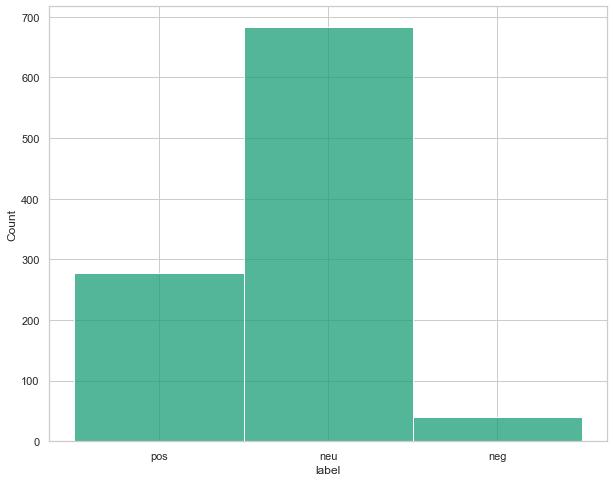

In [ ]:
sns.histplot(shoes.label);

In [ ]:
def shoes_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
shoes_sub = shoes.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
shoes_title_output(shoes_sub, "pos")

print("\nNeutral news")
shoes_title_output(shoes_sub, "neu")

print("\nNegative news")
shoes_title_output(shoes_sub, "neg")

Positive news
not bad for $35
Hydro dipped these pair of UB a few months back and then added some boosted stripes and laces. Really changed the look of these. I have done 4 pair now and these are still my favorite.
Newest cop. Absolutely in love.
Rocking my Ultra Boost 20 at work today
The vault…. In all it’s glory.

Neutral news
Copped these today
Red Gazelle x Red Firebird. Both models will never get old! #casuals
Almost 2 years with these
Adidas send me different sized slides plus neither of them are the actual size that I ordered.
Perks of being an employee

Negative news
New adidas x Star Wars collab came in just in time for tonight
Just added these bad boys to my collection!
Finished a video tutorial showing how to dye your Adidas Alphaedge 4d midsole, for a murdered out look. DM me for the full video. ✌️
No double black mask , no problem.
Attack on Titan Ultraboost


In [ ]:
stop_words = stopwords.words('english')
def custom_tokenize(text): 
  # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()

  # split on words only 
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')  
    tokens = tk.tokenize(text)
    

  # remove stop words
    words = [w for w in tokens if not w in stop_words] 
    return words

In [ ]:
def tokens_2_words(df, label):
  # subset titles based on label
    titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(shoes, 'pos')
neg_words = tokens_2_words(shoes, 'neg')

In [ ]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('adidas', 47),
 ('boost', 42),
 ('love', 41),
 ('got', 28),
 ('pair', 27),
 ('first', 22),
 ('shoes', 19),
 ('ultra', 15),
 ('new', 15),
 ('finally', 14),
 ('happy', 14),
 ('one', 13),
 ('nice', 13),
 ('good', 13),
 ('yeezy', 12),
 ('really', 12),
 ('think', 11),
 ('best', 11),
 ('today', 10),
 ('favorite', 10)]

In [ ]:
pos_im = [str(p) for p in pos_words] 
pos_str = ",".join(pos_im) 
neg_im = [str(p) for p in neg_words] 
neg_str = ",".join(neg_im)

<function matplotlib.pyplot.show(close=None, block=None)>

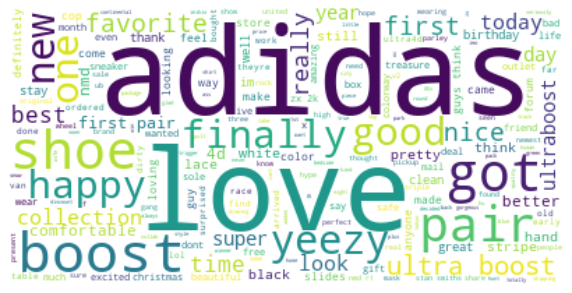

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_pos = WordCloud(background_color = "white").generate(pos_str)
word_cloud_neg = WordCloud().generate(neg_str)
plt.imshow(word_cloud_pos,interpolation = "bilinear") 
plt.axis("off") 
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

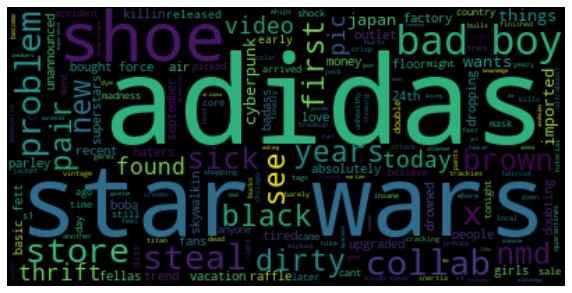

In [ ]:
plt.imshow(word_cloud_neg,interpolation = "bilinear") 
plt.axis("off") 
plt.show